## **COVID-19 CHEST X-RAY IMAGE CLASSIFICATION USING DEEP LEARNING**

## **1. Overview**
This Jupyter notebook covers various steps of implementing both, our own CNN architecture as well as different pre-trained models in order to build and select the best image classification model that detects Covid-19 from x-ray images.

### **1.1 Import libraries**

In [ ]:
import time
import os
import cv2
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from sklearn.metrics import *
from PIL import Image
import shutil

num_workers = 4 #change this parameter based on your system configuration
batch_size = 32 #change this parameter based on your system configuration
seed = 24
random.seed(seed)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['COVID19', 'NORMAL', 'PNEUMONIA']
num_classes = len(categories)
splits = ['train', 'val', 'test']
#DATA_PATH =  #Insert data path name
#MODEL_PATH = #Insert model path name

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **2. Load data from external source**

Download the dataset (archive.zip) from external datasource: https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia

### **2.1. Unzip the archieve.zip dataset downloaded from Kaggle**

Downloaded zip file from Kaggle includes folders with x-ray images distributed as train (80%) and test (20%) datasets.

Follow these steps for uploading the dataset to Google Colab environment:

1.   Upload the archive.zip to google drive and mount the drive in Colab 
2.   Copy the zip file from mount drive to Colab folder
1.   Unzip the file
2.   Set the data path to unzipped file location


In [ ]:
#### Choose either of the following methods based on your coding environment to extract train and test folders 

##1. Local machine
# Train and test folders will be created inside the DATA_PATH(local machine)
import zipfile
##zip_file = #Assign the file path where zip file downloaded
#with ZipFile(zip_file, 'r') as zipObj:
   #zipObj.extractall(os.path.dirname(zip_file))

##2. Google Colab
# To create Train and test folders inside the Google Colab DATA_PATH
!cp '/content/drive/MyDrive/chest-xray-data/archive.zip' '/content'
local_zip = '/content/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:
DATA_PATH = '/content/Data'
model_path = '/content'

### **2.2. Split original test folder randomly and equaly between new test and validation folders**

Transform original train (80%) and test (20%) split in a new train (80%), validation (10%) and test (10%) split

In [ ]:
# Split original test folder randomly and equaly between test and validation (new) folders
if not os.path.isdir(os.path.join(DATA_PATH, 'val')):
    os.mkdir(os.path.join(DATA_PATH, 'val'))
    for subdir in categories:   
        for root, dirs, files in os.walk(os.path.join(DATA_PATH, 'test/'+subdir)):
            size = len(files)
            migrate_index = random.sample(range(size), int(size/2))
            files_to_migrate = [files[i] for i in migrate_index]
            for file in files_to_migrate:
                file_path = os.path.join(DATA_PATH, 'test/' + subdir + '/' + file)
                new_dir = os.path.join(DATA_PATH, 'val/' + subdir)
                if not os.path.exists(new_dir):
                    os.mkdir(new_dir)
                if not os.path.exists(os.path.join(new_dir, file)):
                    a = shutil.move(file_path, new_dir)
else: print("Folder 'val' is already available and the split didn't happen")

Folder 'val' is already available and the split didn't happen


## **3. Image count statistics**

Dataset contains 6,432 images of seggreated into three different types: 

- Covid-19 patient x-ray image (code 0)
- Normal (healthy) person x-ray image (code 1)
- Pneumonia patient x-ray image (code 2)

In [ ]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','']
    print(df)
    return df
df_dataset = show_dataset()

          code train  val test  total
COVID19      0   460   58   58    576
NORMAL       1  1266  158  159   1583
PNEUMONIA    2  3418  427  428   4273
TOTAL           5144  643  645   6432


## **4. Image augmentation and load data**

Use python's transform module to perform following image augmentation steps:

1.   Resize the x-ray image to the image of shape(224, 224) uniformly
2.   Apply centercrop function to crop the center part of the image of shape (224, 224). For inception use size of 299
1.   Convert image to tensor
2.   Load train and test data using ImageFolder function
5.   Concatenate the train and test dataset




In [ ]:
def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform_dict = {
        'model': transforms.Compose(
                                    [transforms.Resize(299),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform_dict['model'])
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, train_loader, val_data, val_loader, test_data, test_loader

train_data, train_loader, val_data, val_loader, test_data, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

In [ ]:
len(dataset)

6432

## **5. GPU**

If available, enable GPU capacity for model building exercise 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cuda


## **6. Visualization**

Visualize a batch of images representing train dataset

Class: COVID19


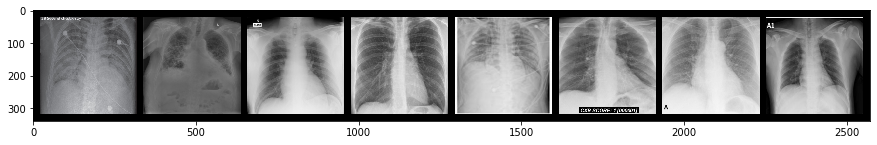

Class: NORMAL


<Figure size 432x288 with 0 Axes>

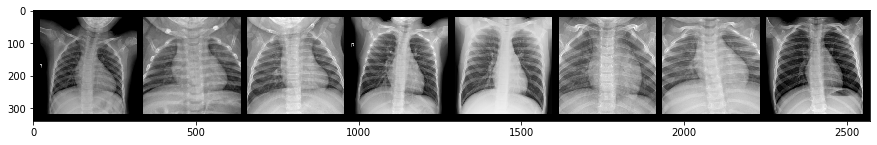

Class: PNEUMONIA


<Figure size 432x288 with 0 Axes>

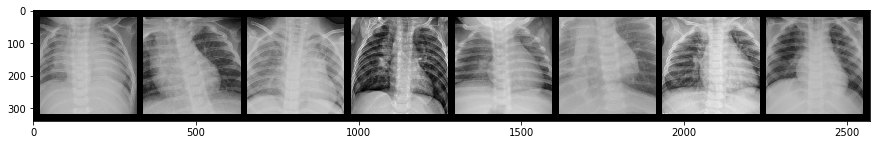

<Figure size 432x288 with 0 Axes>

In [ ]:
def show_batch_images(dataset):
    n_images, scale = 8, 3
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle = True)
    images, labels = next(iter(data_loader))
    for i in range(len(categories)):
        print(f'Class: {categories[i]}')
        images_category = images[labels==i][:n_images]
        grid = torchvision.utils.make_grid(images_category, padding=20)
        npgrid = grid.cpu().numpy()
        plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
        plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        plt.show()
        plt.savefig('x-ray[i].pdf')  
        #plt.savefig("viz1.png", bbox_inches='tight')

show_batch_images(train_data)

## **7. Define the supporting modules**

### **7.1 Calculate metrics, plot loss graph and create confusion matrix**

In [ ]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'val'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

### **7.2 Create the train, evaluation and test modules**

In [ ]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def calc_pred_actuals(model, loader):
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
    return predictions, actuals

def train_val_model(model):
    t_start = time.time()
    global best_val_model
    global best_val_loss
    best_val_loss = 1
    global best_val_epoch
    best_val_epoch = 0
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'val'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    train_size, val_size = len(train_loader), len(val_loader)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t val loss={val_loss/val_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size]
        if epoch >= best_val_epoch + 15:
            break
        if use_scheduler: scheduler.step(val_loss/val_size)   # Optional to use scheduler for dynamic learning rate
    #print(f"Best model has val loss={best_val_loss:.5f} for {best_val_epoch} epochs")
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def train_val_model_kfold(model, train_loader_kfold):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and max of {n_epochs} epochs")
    train_size = len(train_loader_kfold)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        #model.train()
        train_loss = 0.0
        for i, (data, target) in enumerate(train_loader_kfold):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size]
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def accuracy_model(model, loader):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = calc_pred_actuals(model, loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

## **8. Model Development: Using our own CNN model**

### **8.1 CNN architecture with three convolutional layers and two linear layers**

In [ ]:
layer = [128, 128, 256, 256, 3]

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, layer[0], 3, padding=1)
        self.bn1 = nn.BatchNorm2d(layer[0])
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(layer[0], layer[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(layer[1])
        self.conv3 = nn.Conv2d(layer[1], layer[2], 3, padding=1)
        self.bn3 = nn.BatchNorm2d(layer[2])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(14 * 14 * layer[2], layer[3])
        self.linear2 = nn.Linear(layer[3], layer[4])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool2(self.relu(self.bn3(self.conv3(x))))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

### **8.2 Train the model with variable number of epochs and learning rate**

- Learning rate starts with 1e-3 and decrease 20% when validation loss didn't progress
- Training process stop if valization loss didn't increase after 15 epochs

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
net = Net().to(device)
model_name = 'DLH_COVID'
n_epochs = 20
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

# Optional: use_scheduler = True will use dynamic values of learning_rate
#use_scheduler = True  # Set True if using scheduler
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=3, threshold = 0.001,
                                                 #verbose=True, min_lr = 1e-5, threshold_mode = 'abs')
our_model, df_epochs = train_val_model(net)

### **8.3  Plot train and validation losses of our model**

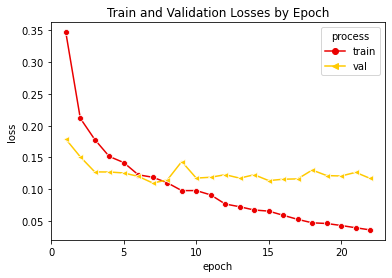

In [ ]:
plot_train_val_losses(df_epochs)

### **8.5 Calculate metrics of best evaluated model using test dataset**



In [ ]:
test_results, conf_matrix_test = accuracy_model(our_model, test_loader)

### **8.6 Show confusion matrix using the test dataset**

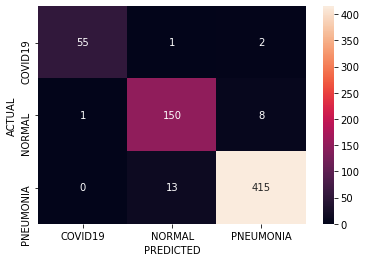

In [ ]:
_ = sns.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

### **8.7 Save final model to be deployed as a web application**

In [ ]:
torch.save(our_model.state_dict(), os.path.join(MODEL_PATH, 'ourmodel.pth'))

## **9. Model Development: using pre-trained modules**
### 9.1 Load pre-trained model
For this image classification exercise, we leveraged 8 different pre-trained models as a part of transfer learning approach:

1. Resnet18, Resnet34, Resnet50 and Resnet101
2. VGG16 and VGG19
3. EfficientNet
4. Inception

All the models have been loaded from the torchvision module. (https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

By default, when we load a pretrained model all of the parameters have .requires_grad=True. But we trained only the last layer hence we set the attribute requires_grad=False.


In [ ]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "resnet34":
        model_ft = models.resnet34(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "resnet50":
        model_ft = models.resnet50(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "resnet101":
        model_ft = models.resnet101(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg16":
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    elif model_name == "vgg19":
        model_ft = models.vgg19_bn(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    elif model_name == "EfficientNet":
        from efficientnet_pytorch import EfficientNet
        model_ft = EfficientNet.from_pretrained('efficientnet-b7',num_classes=num_classes)

    elif model_name == "inception":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = False
            #param.aux_logits = False    
        #num_ftrs = model_ft.fc.in_features
        #model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        model_ft.aux_logits = False
    
    else:
        print("Invalid model name, exiting...")
        exit()
    
    model_ft.to(device)
    return model_ft

### **9.2 Pre-trained model example: VGG19**

Pass model name as parameter to run pre-trained model of your preference.

In [ ]:
#vgg_model = initialize_model("vgg19", num_classes, use_pretrained=True)

inception_model = initialize_model("inception", num_classes, use_pretrained=True)

### **9.3 Train the INCEPTION model**

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
model_name = 'INCEPTION'
n_epochs = 20
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(inception_model.parameters(), lr=learning_rate)
use_scheduler = False   # Set True if using scheduler
pretrained_model, df_inception_epochs = train_val_model(inception_model)

### **9.4  Plot train and validation losses of the VGG19 model**

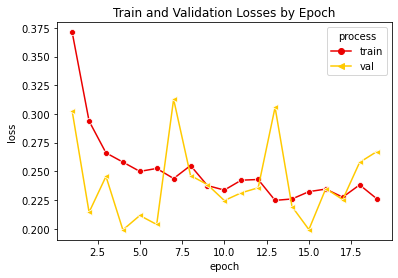

In [ ]:
plot_train_val_losses(df_inception_epochs)

### **9.5 Calculate metrics of best INCEPTION eval model using test dataset**

In [ ]:
test_inception_results, conf_inception_matrix_test = accuracy_model(pretrained_model, test_loader)

Testing the model INCEPTION with 645 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.934884    0.93701  0.895207  0.914396


### **9.6 Show confusion matrix for test dataset**

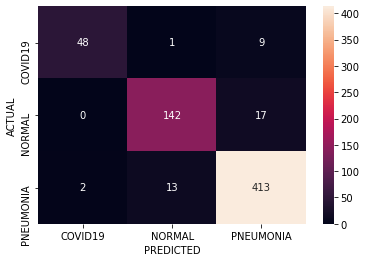

In [ ]:
_ = sns.heatmap(conf_inception_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

## **10 K-Fold Cross Validation**

Use k-fold cross validation technique to evaludate models as follows:

1.   Set k=5 to perform cross validation using 5 folds.
2.   Generate train and test data using random sampler for each fold.
1.   Perform forward propagation using pre-trained model
2.   Calculate train loss and perform optimization with zero gradient
1.   Evaluation the model using test data
2.   Calculate accuracy measures such as accuracy score, precision, recall and F1-score.

In [ ]:
from sklearn.model_selection import KFold
def validate_model_kfold(model, model_name, k_folds):
    #model.eval()
    print(f"Validating the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {k_folds}-folds \n")
    df = pd.DataFrame(columns = metrics)
    kfold = KFold(n_splits=k_folds, shuffle=True)
    print(len(dataset))
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        train_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_subsampler)
        test_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_subsampler)
        #model.apply(reset_weights)
        model, df_vgg_epochs = train_val_model_kfold(model, train_kfold_loader)
        predictions, actuals = calc_pred_actuals(model, test_kfold_loader)
        conf_matrix = create_confusion_matrix(predictions, actuals)
        df_aux = calc_metrics(predictions, actuals, 'FOLD '+str(fold+1))
        df = df.append(df_aux)      
    df.loc['Average'] = df.mean(axis=0)
    print(df.astype(float))
    return df.astype(float), conf_matrix

### **10.1 K-fold cross validation on pre-trained model**

In [ ]:
validation_our_model_results, conf_matrix_our_model_val = validate_model_kfold(inception_model, model_name = 'INCEPTION', k_folds = 5)


Validating the model INCEPTION with 5144 samples and 5-folds 

6432
Training model INCEPTION with 5144 samples and max of 20 epochs
Epoch 1:	 train loss=0.61886 	 time=65.99s
Epoch 2:	 train loss=0.43068 	 time=65.54s
Epoch 3:	 train loss=0.37768 	 time=66.74s
Epoch 4:	 train loss=0.34404 	 time=65.91s
Epoch 5:	 train loss=0.31846 	 time=66.14s
Epoch 6:	 train loss=0.31291 	 time=65.74s
Epoch 7:	 train loss=0.29138 	 time=65.73s
Epoch 8:	 train loss=0.28623 	 time=65.29s
Epoch 9:	 train loss=0.28397 	 time=65.79s
Epoch 10:	 train loss=0.27436 	 time=66.25s
Epoch 11:	 train loss=0.27320 	 time=65.28s
Epoch 12:	 train loss=0.27379 	 time=65.69s
Epoch 13:	 train loss=0.27051 	 time=65.95s
Epoch 14:	 train loss=0.26145 	 time=65.29s
Epoch 15:	 train loss=0.26776 	 time=65.34s
Epoch 16:	 train loss=0.26493 	 time=66.24s
Epoch 17:	 train loss=0.25656 	 time=67.49s
Epoch 18:	 train loss=0.25719 	 time=66.46s
Epoch 19:	 train loss=0.25813 	 time=66.81s
Epoch 20:	 train loss=0.25281 	 time=66.1

### **10.2 K-fold cross validation on our CNN model**

In [ ]:
validation_our_model_results, conf_matrix_our_model_val = validate_model_kfold(net, model_name = 'DLH_TEAM', k_folds = 5)


## **11 Web application using the best CNN model saved on 8.7**

After defining that the best model was our own CNN architecture trained, we saved it (session 8.7) and used to deploy a free public web application using technologies such as containers and cloud app infrasctructure (Microsoft Azure).

You can check the accuracy of our model accesing the link: https://toad.li/xray